In [1]:
import os
import xml.etree.ElementTree as ex

os.environ["CUDA_VISIBLE_DEVICES"]="4"

sample_labels = ["LMCI", "EMCI"]
label_to_id = {}      # key: class name
                    # value: class id
file_to_apoe = {}   # key: image file path
                    # value: boolean, true if image specified 4 in either "APOE A1" or "APOE A2" fields

# This is for getting ADNI files
def get_filenames(folder, metadata_folder):
    global label_to_id
    for i, label in enumerate(sample_labels):
        label_to_id[label] = i
         
    # Get list of images
    image_class = {} # key: unique subject id in filename
                     # value: image file path
    for root, directories, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith("nii") and "__Scaled_2" not in root:
                identifier = filename[-11:-4]
                image_class[identifier] = os.path.join(root,filename)
                
    meta_files = [f for f in os.listdir(metadata_folder) if f.endswith('xml')]
        
    # Label each image
    classify_by_label = {} # key: label class in [0, 1, 2, 3]
                           # value: list of image file paths
    for xml in meta_files:
        if "__Scaled_2" not in xml:
            identifier = xml[-11:-4]
            root = ex.parse(metadata_folder + "/" + xml).getroot()
            classification = root[0][3][1].text
            if classification in label_to_id:
                cl = label_to_id[classification]
                file_path = image_class[identifier]
                if cl not in classify_by_label:
                    classify_by_label[cl] = [file_path]
                else:
                    classify_by_label[cl].append(file_path)
                
                # Storing APOE e4 carrier information for each image file
                apoe_1 = root[0][3][4].text
                apoe_2 = root[0][3][5].text
                
                file_to_apoe[file_path] = False
                if apoe_1 == "4" or apoe_2 == "4":
                    file_to_apoe[file_path] = True
                    
    print("Statistics: {}".format(get_stats(classify_by_label)))
    
    return classify_by_label

def get_stats(files):
    stats = {}
    for k, v in files.items():
        stats[sample_labels[int(k)]] = len(v)
    return stats


In [2]:
import matplotlib.pyplot as plt
from nilearn import image
import nibabel as nib
import numpy as np
import tensorflow as tf
from scipy import ndimage as nd

def get_files(data_folder, metadata_folder):
    files = get_filenames(data_folder, metadata_folder)
    return files 

# Size of desired image
width = 80
height = 80
depth = 80

def get_data(files, class_id):
    global width, height, depth
    num_images = len(files)
    
    x_data = np.zeros([num_images, height, width, depth], np.float32)
    y_data = np.zeros(num_images, dtype=np.int32)
    
    for i in range(num_images):
        loaded_img = nib.load(files[i])    
        im = loaded_img.get_data()
        im = nd.interpolation.zoom(im, 
                                   zoom = np.array([height, width, depth])/im.shape)

        x_data[i] = np.asarray(im, dtype=np.float32)
        y_data[i] = class_id
    
    x_data_ = x_data.reshape(num_images, height * width * depth)
    return x_data_, y_data

In [3]:
def partition_data(num_result, class_data, class_id):
    random_inds = random.sample(range(0, len(class_data)), num_result)
    random_inds = sorted(random_inds, reverse=True)
    files = []
    for ind in random_inds:
        files.append(class_data.pop(ind))
    data, target = get_data(files, class_id)
    
    return data, target, files
    

In [4]:
import math
import random

# Get training data
files = get_files('ADNI2_all/ADNI', 'ADNI2_all/metadata')
num_samples = 0
flattened = [[] for i in range(len(sample_labels))]
for k, v in files.items():
    for f in v:
        flattened[k].append(f) 
        num_samples += 1

# Store APOE e4 carrier statistics on test data
apoe_test_files = []
e4_carrier_stats_pre = {}
for i in range(0, len(sample_labels)):
    e4_carrier_stats_pre[i] = 0
    
num_val_samples_per_cl = 8
num_test_samples_per_cl = 16

# Split training and testing data
tr_data = []
tr_target = []
val_data = []
val_target = []
test_data = []
test_target = []
for cl in range(0, len(flattened)): 
    # Get testing data
    data, target, files = partition_data(num_test_samples_per_cl, flattened[cl], cl)
    if len(test_data) == 0:
        test_data = data
        test_target = target
    else:
        test_data = np.append(test_data, data, axis=0)
        test_target = np.append(test_target, target)
                
    # Increment values if e4 carrier status
    apoe_test_files = np.append(apoe_test_files, files)
    for f in files:
        if file_to_apoe[f]:
            e4_carrier_stats_pre[cl] += 1
    
    # Get validation data
    data, target, files = partition_data(num_val_samples_per_cl, flattened[cl], cl)
    if len(val_data) == 0:
        val_data = data
        val_target = target
    else:
        val_data = np.append(val_data, data, axis=0)
        val_target = np.append(val_target, target)
    
    # Get training data
    data, target = get_data(flattened[cl], cl)
    if len(tr_data) == 0:
        tr_data = data
        tr_target = target
    else:
        tr_data = np.append(tr_data, data, axis=0)
        tr_target = np.append(tr_target, target)
    
# Print e4 carrier stats
for cl_id, quant in e4_carrier_stats_pre.items():
    print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], quant/num_test_samples_per_cl))

Statistics: {'EMCI': 264, 'LMCI': 178}
Class LMCI. Pct APOE e4 carrier 0.875
Class EMCI. Pct APOE e4 carrier 0.5625


In [5]:
def weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv3d(x, W, bias, strides=[1, 1, 1, 1, 1]):
    conv = tf.nn.conv3d(x, W, strides, padding='SAME') 
    bias = tf.nn.bias_add(conv, bias)
    return tf.nn.relu(bias)

def batch_norm(x, training):
    return tf.layers.batch_normalization(x, training = training)

def max_pool_2x2(x):
    return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')

In [6]:
# Create network
tf.reset_default_graph()

x = tf.placeholder(shape = [None, width*height*depth],
                   dtype = tf.float32)
training = tf.placeholder(shape = None,
                          dtype = tf.bool)

x_image = tf.reshape(x, [-1, height, width, depth, 1])

W = weight([3, 3, 3, 1, 8])
b = bias([8])
conv1 = conv3d(x_image, W, b)

W = weight([3, 3, 3, 8, 8])
conv2 = conv3d(conv1, W, b)
pool3 = max_pool_2x2(conv2)

W = weight([3, 3, 3, 8, 16])
b = bias([16])
conv4 = conv3d(pool3, W, b)

W = weight([3, 3, 3, 16, 16])
conv5 = conv3d(conv4, W, b)
pool6 = max_pool_2x2(conv5)

W = weight([3, 3, 3, 16, 32])
b = bias([32])
conv7 = conv3d(pool6, W, b)

W = weight([3, 3, 3, 32, 32])
conv8 = conv3d(conv7, W, b)
conv9 = conv3d(conv8, W, b)
pool10 = max_pool_2x2(conv9)

W = weight([3, 3, 3, 32, 64])
b = bias([64])
conv11 = conv3d(pool10, W, b)

W = weight([3, 3, 3, 64, 64])
conv12 = conv3d(conv11, W, b)
conv13 = conv3d(conv12, W, b)
pool14 = max_pool_2x2(conv13)

# Densely Connected Layer (or fully-connected layer)
pool_flat = tf.layers.flatten(pool14)
fcl1 = tf.layers.dense(pool_flat, units=128, activation = tf.nn.relu)
bn1 = batch_norm(fcl1, training)
fcl2 = tf.layers.dense(bn1, units=64, activation = tf.nn.relu)
logits = tf.layers.dense(fcl2,
                         units = len(sample_labels),
                         activation = tf.nn.softmax)

# Loss
y_ = tf.placeholder(shape = [None],
                    dtype = tf.int32)
y_onehot = tf.one_hot(y_, len(sample_labels))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_onehot, logits=logits))

# Classification Accuracy
predicted = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted, tf.argmax(y_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimizer
opt = tf.train.AdamOptimizer(27e-6).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
# Plotting variables
x_train = []
y_train = []
x_val = []
y_val = []
x_tr_acc = []
y_tr_acc = []
x_val_acc = []
y_val_acc = []

def plotting(train_loss, val_loss, train_acc, val_acc, final=False):
    if final:
        plt.figure(figsize=(20,10))
    plt.scatter(train_loss[0], train_loss[1], color='g', s=1, label='training')
    plt.scatter(val_loss[0], val_loss[1], color='r', s=1, label='validation')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.show()

    if final:
        plt.figure(figsize=(20,10))
    plt.scatter(train_acc[0], train_acc[1], color='g', s=1, label='training')
    plt.scatter(val_acc[0], val_acc[1], color='r', s=1, label='validation')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend()
    plt.show()


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0. Curr loss 0.8132616281509399.
Epoch 0. TrainL 0.6791583895683289. ValL 0.8132616281509399. Acc 0.5.


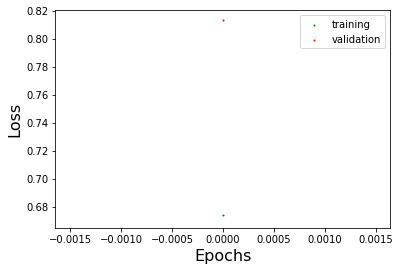

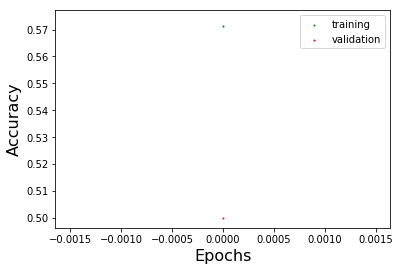

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 1. TrainL 0.6087291240692139. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616877555847.
Epoch 2. TrainL 0.6256279945373535. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616877555847. Curr loss 0.8132616281509399.
Epoch 3. TrainL 0.5976142883300781. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 4. TrainL 0.5149755477905273. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132615685462952.
Epoch 5. TrainL 0.5286021828651428. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132615685462952. Curr loss 0.8132615685462952.
Epoch 6. TrainL 0.5431829690933228. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1

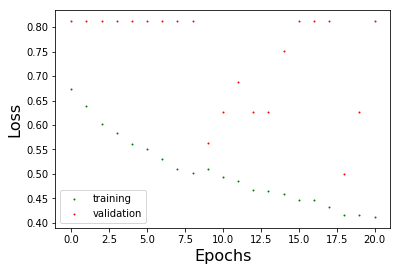

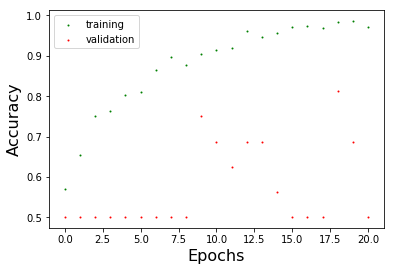

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7418331503868103. Curr loss 0.7422389984130859.
Epoch 21. TrainL 0.40565213561058044. ValL 0.7507616281509399. Acc 0.5625.
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7422389984130859. Curr loss 0.7398921251296997.
Epoch 22. TrainL 0.3743690848350525. ValL 0.6882616281509399. Acc 0.625.
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7398921251296997. Curr loss 0.7403450012207031.
Epoch 23. TrainL 0.39133819937705994. ValL 0.7507616281509399. Acc 0.5625.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7403450012207031. Curr loss 0.7432616353034973.
Epoch 24. TrainL 0.3788290023803711. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7432616353034973. Curr loss 0.7459539175033569.
Epoch 25. TrainL 0.40217554569244385. ValL 0.8132616281509399. Acc 0.5.
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7459539175033569. Curr loss 0.746131956577301.
Epoch 26. TrainL 0.3847535252571106. ValL 0.7507616281509399. Acc 0.562

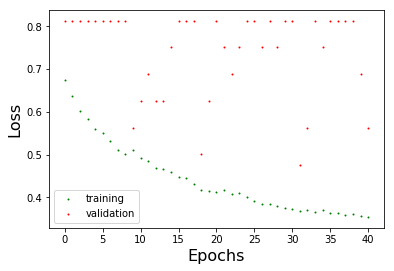

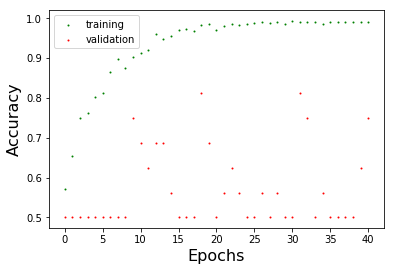

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7425389885902405. Curr loss 0.7412466406822205.
Epoch 41. TrainL 0.35391202569007874. ValL 0.6882616281509399. Acc 0.625.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7412466406822205. Curr loss 0.7371074557304382.
Epoch 42. TrainL 0.3447222113609314. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7371074557304382. Curr loss 0.7388381958007812.
Epoch 43. TrainL 0.35343581438064575. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7388381958007812. Curr loss 0.734936535358429.
Epoch 44. TrainL 0.35667380690574646. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.734936535358429. Curr loss 0.7312045097351074.
Epoch 45. TrainL 0.3367023468017578. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7312045097351074. Curr loss 0.7289610505104065.
Epoch 46. TrainL 0.37318283319473267. ValL 0.6257616281509399. Acc 0.6875.


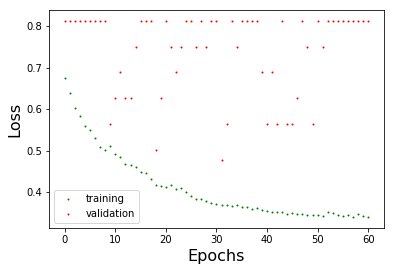

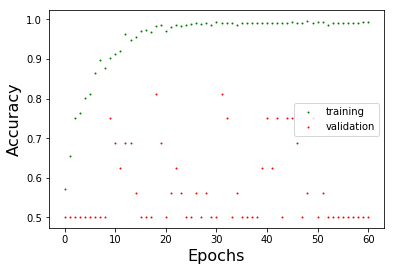

[0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1]
Last loss 0.7352690100669861. Curr loss 0.7327690124511719.
Epoch 61. TrainL 0.3622261583805084. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7327690124511719. Curr loss 0.7365190386772156.
Epoch 62. TrainL 0.34628960490226746. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1]
Last loss 0.7365190386772156. Curr loss 0.7352690100669861.
Epoch 63. TrainL 0.35584744811058044. ValL 0.5632616281509399. Acc 0.75.
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7352690100669861. Curr loss 0.7352690100669861.
Epoch 64. TrainL 0.3301859498023987. ValL 0.7507616281509399. Acc 0.5625.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7352690100669861. Curr loss 0.7302690148353577.
Epoch 65. TrainL 0.32625362277030945. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7302690148353577. Curr loss 0.7302690148353577.
Epoch 66. TrainL 0.3489445447921753. ValL 0.8132616281509399. Acc 0.5.
[

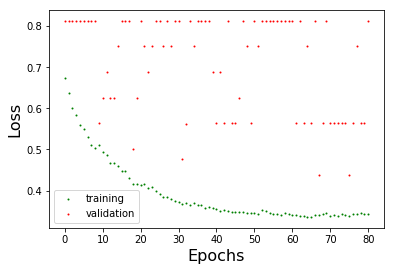

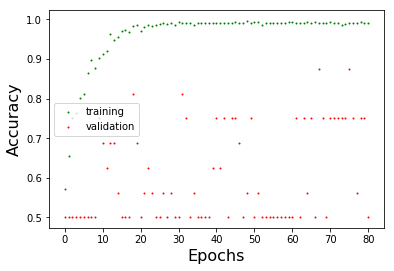

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6865192651748657. Curr loss 0.6932579278945923.
Epoch 81. TrainL 0.3601832985877991. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6932579278945923. Curr loss 0.6982617974281311.
Epoch 82. TrainL 0.3469820022583008. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6982617974281311. Curr loss 0.6970117688179016.
Epoch 83. TrainL 0.3534350097179413. ValL 0.7507616281509399. Acc 0.5625.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6970117688179016. Curr loss 0.6932618021965027.
Epoch 84. TrainL 0.32622021436691284. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6932618021965027. Curr loss 0.6920117735862732.
Epoch 85. TrainL 0.3506726324558258. ValL 0.7507616281509399. Acc 0.5625.
[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.6920117735862732. Curr loss 0.6857618093490601.
Epoch 86. TrainL 0.3338946998119354. ValL 0.5007616281509399. Acc 0.8125.

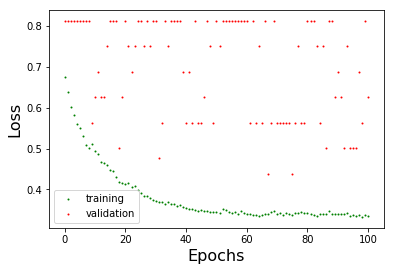

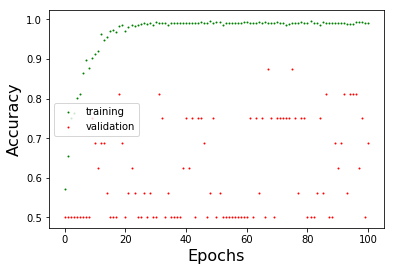

[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6732675433158875. Curr loss 0.6695175170898438.
Epoch 101. TrainL 0.3256116211414337. ValL 0.5632616281509399. Acc 0.75.
[1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6695175170898438. Curr loss 0.6670175194740295.
Epoch 102. TrainL 0.33425721526145935. ValL 0.6882616281509399. Acc 0.625.
[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.6670175194740295. Curr loss 0.6607674360275269.
Epoch 103. TrainL 0.3490709066390991. ValL 0.5007616281509399. Acc 0.8125.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6607674360275269. Curr loss 0.6557674407958984.
Epoch 104. TrainL 0.321821391582489. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6557674407958984. Curr loss 0.6557674407958984.
Epoch 105. TrainL 0.3546159267425537. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1]
Last loss 0.6557674407958984. Curr loss 0.65076744556427.
Epoch 106. TrainL 0.324918270111084. ValL 0.5632616281509399. Acc 0.75.

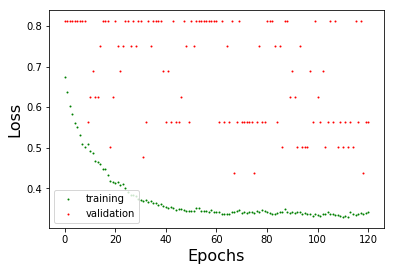

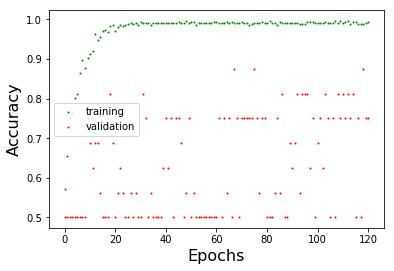

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6220174431800842. Curr loss 0.6270174384117126.
Epoch 121. TrainL 0.34955689311027527. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6270174384117126. Curr loss 0.6270174384117126.
Epoch 122. TrainL 0.32674455642700195. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.6270174384117126. Curr loss 0.6245174407958984.
Epoch 123. TrainL 0.33548682928085327. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.6245174407958984. Curr loss 0.6220174431800842.
Epoch 124. TrainL 0.3308684825897217. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.6220174431800842. Curr loss 0.6232616901397705.
Epoch 125. TrainL 0.3255658745765686. ValL 0.5004845261573792. Acc 0.8125.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6232616901397705. Curr loss 0.6232617497444153.
Epoch 126. TrainL 0.35328853130340576. ValL 0.5632616281509399.

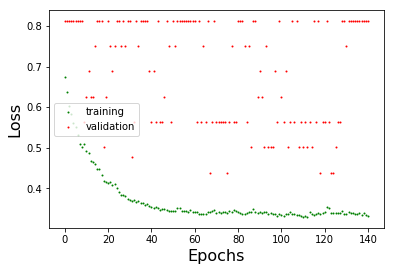

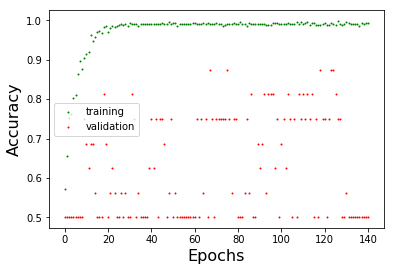

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6482617855072021. Curr loss 0.6520116925239563.
Epoch 141. TrainL 0.34179478883743286. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6520116925239563. Curr loss 0.658261775970459.
Epoch 142. TrainL 0.35413920879364014. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.658261775970459. Curr loss 0.6595118045806885.
Epoch 143. TrainL 0.3245450258255005. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6595118045806885. Curr loss 0.6657617688179016.
Epoch 144. TrainL 0.3491063416004181. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6657617688179016. Curr loss 0.6720117926597595.
Epoch 145. TrainL 0.3212224841117859. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6720117926597595. Curr loss 0.678256094455719.
Epoch 146. TrainL 0.32128655910491943. ValL 0.8132616281509399. Acc 0.5.
[1 1

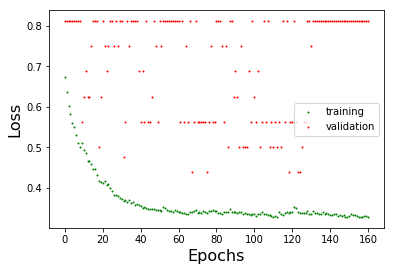

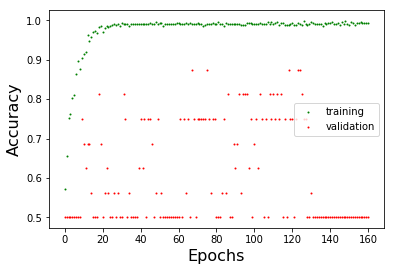

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7307560443878174. Curr loss 0.7357560992240906.
Epoch 161. TrainL 0.3216037154197693. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7357560992240906. Curr loss 0.7420060634613037.
Epoch 162. TrainL 0.32401084899902344. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7420060634613037. Curr loss 0.7470060586929321.
Epoch 163. TrainL 0.3378775119781494. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7470060586929321. Curr loss 0.75325608253479.
Epoch 164. TrainL 0.3220747113227844. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.75325608253479. Curr loss 0.75325608253479.
Epoch 165. TrainL 0.3228578567504883. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.75325608253479. Curr loss 0.7582560777664185.
Epoch 166. TrainL 0.3255946636199951. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 

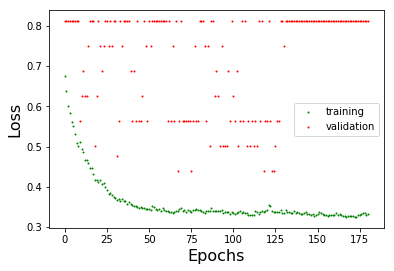

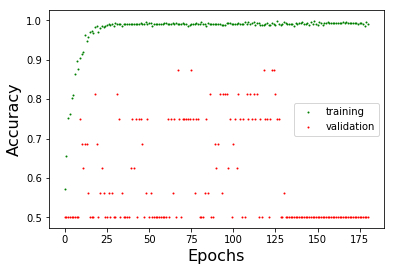

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 181. TrainL 0.3352638781070709. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 182. TrainL 0.3225950598716736. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 183. TrainL 0.3211122155189514. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 184. TrainL 0.32089218497276306. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 185. TrainL 0.3173154592514038. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 186. TrainL 0.35227763652801514. ValL 0.8132616281509399. Acc 0.5.
[1

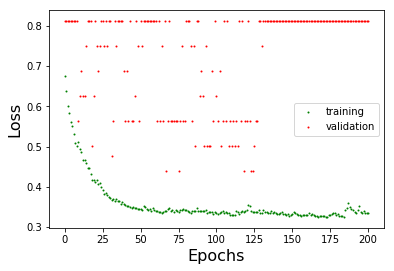

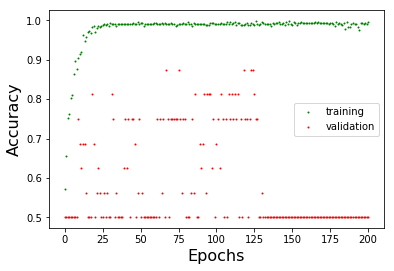

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 201. TrainL 0.3229352831840515. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 202. TrainL 0.35599690675735474. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 203. TrainL 0.3221744894981384. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 204. TrainL 0.3239005208015442. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 205. TrainL 0.32424408197402954. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 206. TrainL 0.34546563029289246. ValL 0.8132616281509399. Acc 0.5.
[

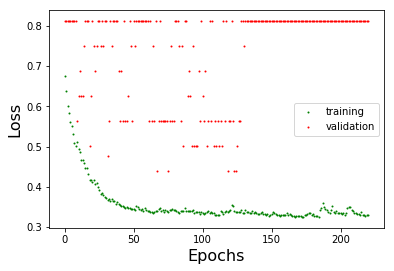

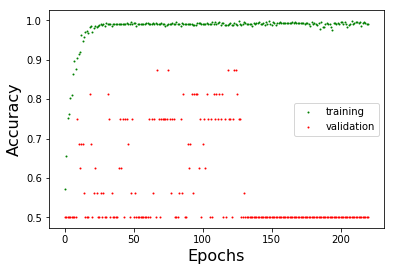

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 221. TrainL 0.3291422128677368. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 222. TrainL 0.35828226804733276. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 223. TrainL 0.32725220918655396. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 224. TrainL 0.31871992349624634. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 225. TrainL 0.31874924898147583. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 226. TrainL 0.3228190839290619. ValL 0.8132616281509399. Acc 0.5.


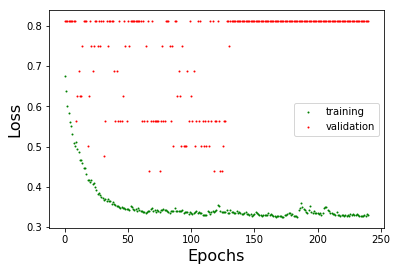

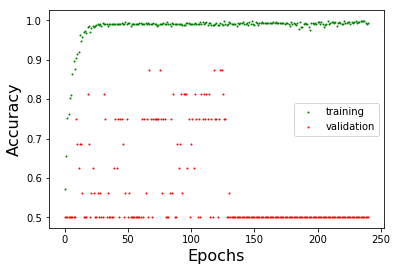

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 241. TrainL 0.32053303718566895. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 242. TrainL 0.3210026025772095. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 243. TrainL 0.3341522216796875. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 244. TrainL 0.32307714223861694. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 245. TrainL 0.32507598400115967. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 246. TrainL 0.32008105516433716. ValL 0.8132616281509399. Acc 0.5.


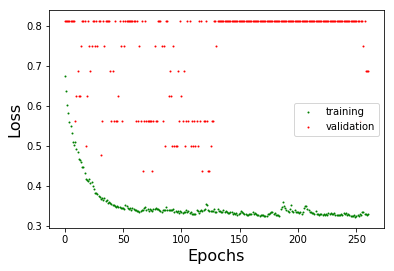

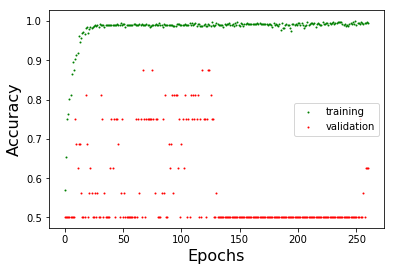

[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7995116710662842. Curr loss 0.794511616230011.
Epoch 261. TrainL 0.32521146535873413. ValL 0.5632616281509399. Acc 0.75.
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.794511616230011. Curr loss 0.7920116186141968.
Epoch 262. TrainL 0.3221548795700073. ValL 0.6882616281509399. Acc 0.625.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7920116186141968. Curr loss 0.7920116186141968.
Epoch 263. TrainL 0.3324238657951355. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7920116186141968. Curr loss 0.7920116186141968.
Epoch 264. TrainL 0.32752910256385803. ValL 0.8132616281509399. Acc 0.5.
[0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7920116186141968. Curr loss 0.7882616519927979.
Epoch 265. TrainL 0.32378101348876953. ValL 0.6257616281509399. Acc 0.6875.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7882616519927979. Curr loss 0.7882616519927979.
Epoch 266. TrainL 0.33255434036254883. ValL 0.8132616281509399. Acc 0

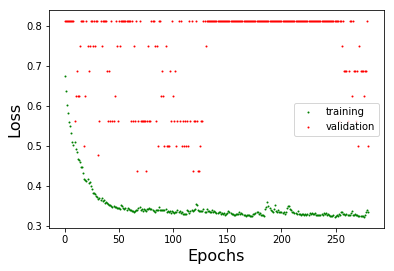

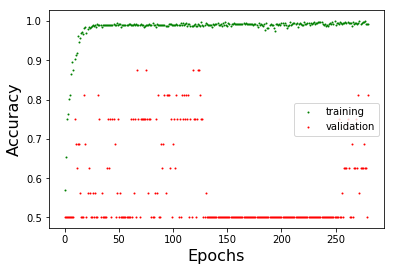

[0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1]
Last loss 0.7457616329193115. Curr loss 0.7370116710662842.
Epoch 281. TrainL 0.3500322103500366. ValL 0.37576162815093994. Acc 0.9375.
[1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7370116710662842. Curr loss 0.7332616448402405.
Epoch 282. TrainL 0.3237278461456299. ValL 0.6257616281509399. Acc 0.6875.
[1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1]
Last loss 0.7332616448402405. Curr loss 0.7282616496086121.
Epoch 283. TrainL 0.32674574851989746. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1]
Last loss 0.7282616496086121. Curr loss 0.7195116281509399.
Epoch 284. TrainL 0.3374980092048645. ValL 0.37576162815093994. Acc 0.9375.
[1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1]
Last loss 0.7195116281509399. Curr loss 0.7132616639137268.
Epoch 285. TrainL 0.34346339106559753. ValL 0.5007616281509399. Acc 0.8125.
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.7132616639137268. Curr loss 0.7107616662979126.
Epoch 286. TrainL 0.39949631690979004. ValL 0.6882616281509

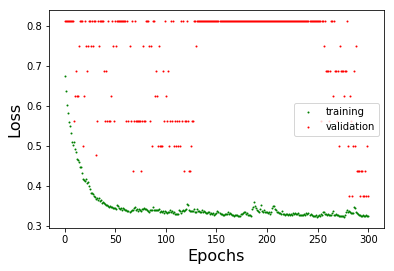

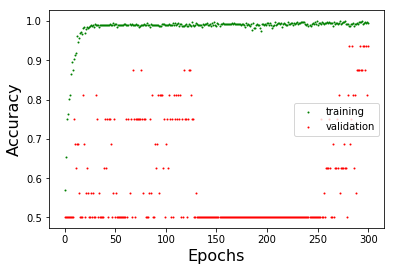

[0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1]
Last loss 0.6082615852355957. Curr loss 0.5995115637779236.
Epoch 301. TrainL 0.32392600178718567. ValL 0.37576162815093994. Acc 0.9375.
[1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1]
Last loss 0.5995115637779236. Curr loss 0.5945115685462952.
Epoch 302. TrainL 0.32053279876708984. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1]
Last loss 0.5945115685462952. Curr loss 0.592011570930481.
Epoch 303. TrainL 0.322374552488327. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1]
Last loss 0.592011570930481. Curr loss 0.5832615494728088.
Epoch 304. TrainL 0.3396247327327728. ValL 0.37576162815093994. Acc 0.9375.
[0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1]
Last loss 0.5832615494728088. Curr loss 0.5757615566253662.
Epoch 305. TrainL 0.3210698664188385. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.5757615566253662. Curr loss 0.5707615613937378.
Epoch 306. TrainL 0.3311721682548523. ValL 0.5007616281509399.

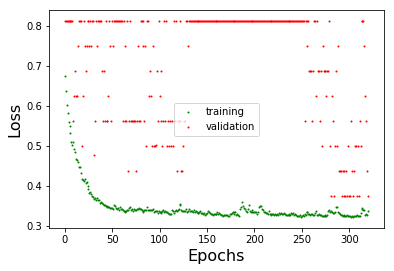

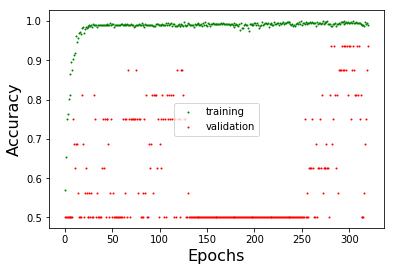

[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.5345115065574646. Curr loss 0.5345115065574646.
Epoch 321. TrainL 0.3303198218345642. ValL 0.5007616281509399. Acc 0.8125.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5345115065574646. Curr loss 0.5307615399360657.
Epoch 322. TrainL 0.32390546798706055. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.5307615399360657. Curr loss 0.5257615447044373.
Epoch 323. TrainL 0.3701213598251343. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.5257615447044373. Curr loss 0.5207615494728088.
Epoch 324. TrainL 0.362119197845459. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1]
Last loss 0.5207615494728088. Curr loss 0.5195115208625793.
Epoch 325. TrainL 0.32529452443122864. ValL 0.6257616281509399. Acc 0.6875.
[1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5195115208625793. Curr loss 0.5195115208625793.
Epoch 326. TrainL 0.34100037813186646. ValL 0.6257616281509399

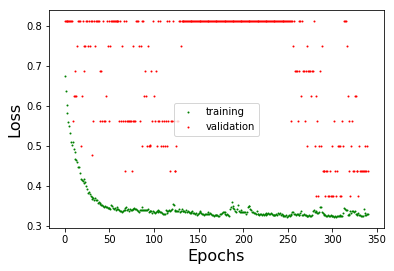

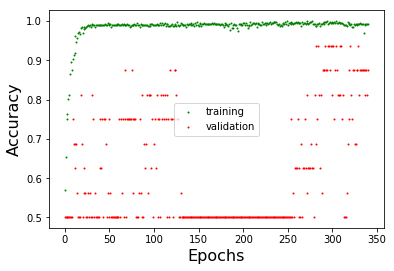

[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.4857615530490875. Curr loss 0.4882615804672241.
Epoch 341. TrainL 0.3277714252471924. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.4882615804672241. Curr loss 0.4895115792751312.
Epoch 342. TrainL 0.31946900486946106. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1]
Last loss 0.4895115792751312. Curr loss 0.48957687616348267.
Epoch 343. TrainL 0.31956058740615845. ValL 0.4415273666381836. Acc 0.875.
[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.48957687616348267. Curr loss 0.49082690477371216.
Epoch 344. TrainL 0.3181421756744385. ValL 0.5007616281509399. Acc 0.8125.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.49082690477371216. Curr loss 0.4920768737792969.
Epoch 345. TrainL 0.3202711045742035. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.4920768737792969. Curr loss 0.493326872587204.
Epoch 346. TrainL 0.32304614782333374. ValL 0.4382616281509

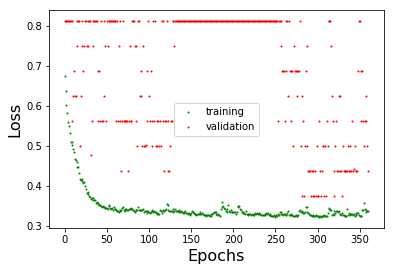

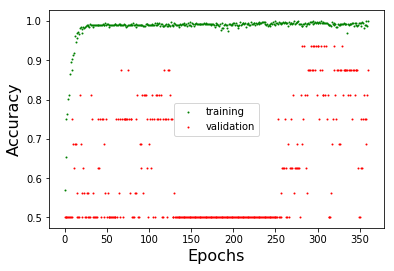

[0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.5395768880844116. Curr loss 0.5383269190788269.
Epoch 361. TrainL 0.3231925368309021. ValL 0.5007616281509399. Acc 0.8125.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5383269190788269. Curr loss 0.5395768880844116.
Epoch 362. TrainL 0.33439287543296814. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5395768880844116. Curr loss 0.5345768928527832.
Epoch 363. TrainL 0.3236828148365021. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5345768928527832. Curr loss 0.5295768976211548.
Epoch 364. TrainL 0.3320947289466858. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1]
Last loss 0.5295768976211548. Curr loss 0.5220769047737122.
Epoch 365. TrainL 0.3655417859554291. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1]
Last loss 0.5220769047737122. Curr loss 0.5170769095420837.
Epoch 366. TrainL 0.3295399248600006. ValL 0.5007616281509399. Acc

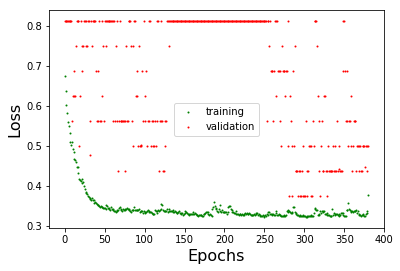

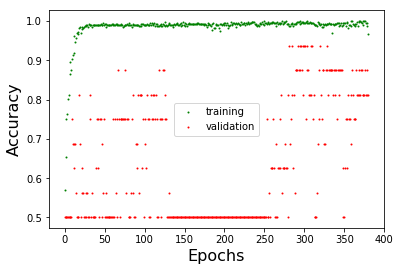

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5122659802436829. Curr loss 0.5197660326957703.
Epoch 381. TrainL 0.4051569402217865. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5197660326957703. Curr loss 0.5272660255432129.
Epoch 382. TrainL 0.45403775572776794. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5272660255432129. Curr loss 0.533515989780426.
Epoch 383. TrainL 0.40343135595321655. ValL 0.7507616281509399. Acc 0.5625.
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.533515989780426. Curr loss 0.5397660136222839.
Epoch 384. TrainL 0.4441545009613037. ValL 0.7507616281509399. Acc 0.5625.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5397660136222839. Curr loss 0.5472660064697266.
Epoch 385. TrainL 0.3848415017127991. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.5472660064697266. Curr loss 0.5535160303115845.
Epoch 386. TrainL 0.38027888536453247. ValL 0.8132616281509399. Acc 0.

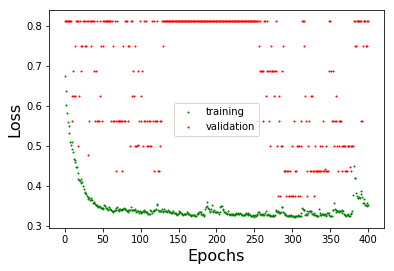

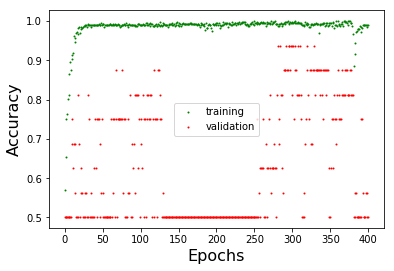

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6197006106376648. Curr loss 0.622200608253479.
Epoch 401. TrainL 0.3700346052646637. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.622200608253479. Curr loss 0.6272006034851074.
Epoch 402. TrainL 0.37619221210479736. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6272006034851074. Curr loss 0.6297006011009216.
Epoch 403. TrainL 0.3549911379814148. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6297006011009216. Curr loss 0.6334506273269653.
Epoch 404. TrainL 0.369748592376709. ValL 0.7507616281509399. Acc 0.5625.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6334506273269653. Curr loss 0.6397006511688232.
Epoch 405. TrainL 0.36186447739601135. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6397006511688232. Curr loss 0.6447006464004517.
Epoch 406. TrainL 0.32950446009635925. ValL 0.8132616281509399. Acc 0.5.
[

In [8]:
saver = tf.train.Saver()

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

# Params for early stopping
patience = 16
patience_cnt = 0
hist_len = 50
last_avg_loss = 0
hist_loss = []
min_loss_seen = None

batch_size = 32
epoch = 0
while (patience_cnt < patience or epoch < hist_len) and epoch < 500:
    c = list(zip(tr_data, tr_target))
    random.shuffle(c)
    tr_data, tr_target = zip(*c)

    tr_loss, val_loss, tr_acc, val_acc = (0, 0, 0, 0)
    for j in range(0, len(tr_target), batch_size):

        # Validation conditions
        if j == 0:
            # Get accuracy and loss from validation data
            vLoss, vAcc, vPred = sess.run([loss, accuracy, predicted], 
                                          feed_dict = {x: val_data,
                                                       y_: val_target,
                                                       training: False})
                   
            print(vPred)
            
            # Conditions for early stopping
            if len(hist_loss) == hist_len:
                hist_loss.pop(0)
            hist_loss.append(vLoss)
            curr_loss = np.mean(np.asarray(hist_loss)) 
            
            print("Last loss {}. Curr loss {}.".format(last_avg_loss, curr_loss))
            
            if last_avg_loss > curr_loss:
                patience_cnt = 0
                
                # Save the model 
                if min_loss_seen == None or min_loss_seen > curr_loss:
                    min_loss_seen = curr_loss
                    saver.save(sess, './voxcnn-model', global_step=epoch)
                    saver.save(sess, './voxcnn-model-final')
            elif last_avg_loss == curr_loss:
                patience_cnt = 0
            else:
                if epoch >= hist_len:
                    patience_cnt += 1
                
            last_avg_loss = curr_loss
                
        # Training
        rOpt, rLoss, rAcc = sess.run([opt, loss, accuracy], 
                                     feed_dict = {x: tr_data[j:j + batch_size],
                                                  y_: tr_target[j:j + batch_size],
                                                  training: True})

        # Accumulate loss and accuracy stats to later calculate average of epoch
        tr_loss += rLoss
        val_loss += vLoss
        tr_acc += rAcc
        val_acc += vAcc

        if j == 0:
            print('Epoch {}. TrainL {}. ValL {}. Acc {}.'.format(epoch, rLoss, vLoss, vAcc))
    
    num_mini_batches = math.ceil(len(tr_target)/batch_size)
    x_train.append(epoch)
    y_train.append(tr_loss/num_mini_batches)
    x_val.append(epoch)
    y_val.append(val_loss/num_mini_batches)
    x_tr_acc.append(epoch)
    y_tr_acc.append(tr_acc/num_mini_batches)
    x_val_acc.append(epoch)
    y_val_acc.append(val_acc/num_mini_batches)
    
    # Plotting every 20 epochs
    if epoch % 20 == 0:
        plotting((x_train, y_train), (x_val, y_val), (x_tr_acc, y_tr_acc), (x_val_acc, y_val_acc))
    
    # Next epoch
    epoch += 1


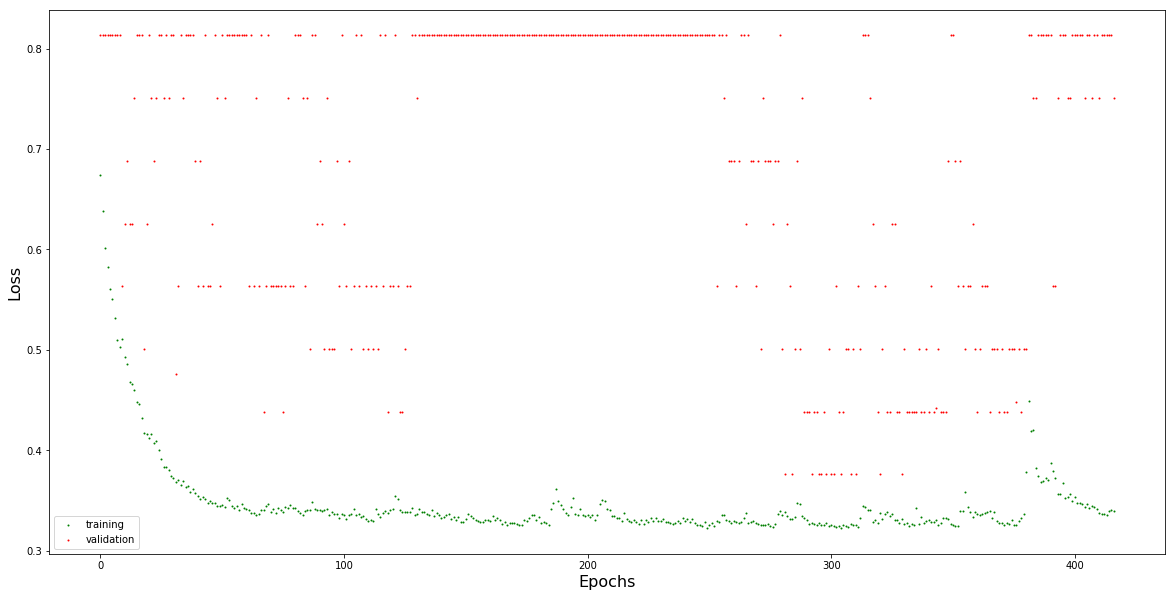

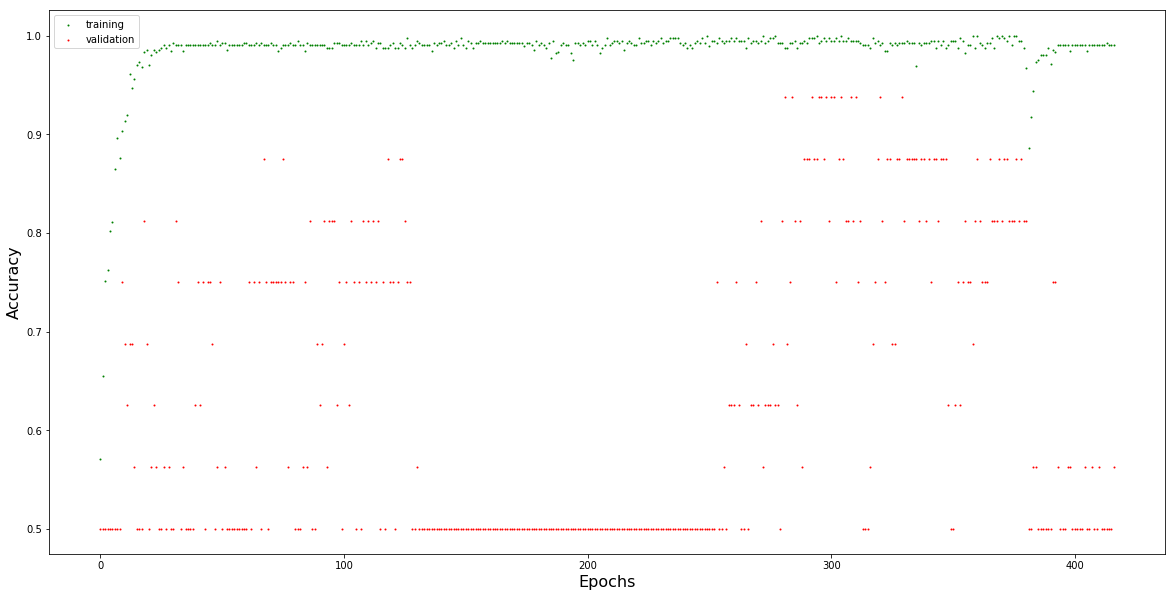

In [9]:
# Plot final graph
plotting((x_train, y_train), (x_val, y_val), (x_tr_acc, y_tr_acc), (x_val_acc, y_val_acc), final=True)


In [10]:
# Need to restore model saved by early stopping
with tf.Session() as sSess:
    # Restore variables.
    saver.restore(sSess, './voxcnn-model-final')
    print("Model restored.")
              
    # Get accuracy and loss from validation data
    sAcc, sPred = sSess.run([accuracy, predicted], 
                            feed_dict = {x: test_data,
                                         y_: test_target,
                                         training: False})
    
    print('Predicted classes {}'.format(sPred))
    print('Testing accuracy {}'.format(sAcc))

    # APOE e4 stats for testing data
    e4_carrier_stats_post = {}
    for k in range(0, len(sample_labels)):
        e4_carrier_stats_post[k] = [0, 0]

    # Get testing APOE e4 stats
    for p in range(0, len(sPred)):
        e4_carrier_stats_post[sPred[p]][1] += 1
        if file_to_apoe[apoe_test_files[p]]:
            e4_carrier_stats_post[sPred[p]][0] += 1

    for cl_id, [quant, num_samples] in e4_carrier_stats_post.items():
        if num_samples != 0:
            print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], 
                                                            quant/num_samples))

INFO:tensorflow:Restoring parameters from ./voxcnn-model-final
Model restored.
Predicted classes [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Testing accuracy 0.9375
Class LMCI. Pct APOE e4 carrier 0.9285714285714286
Class EMCI. Pct APOE e4 carrier 0.5555555555555556
